In [1]:
# Code for neural style tranfer for images

import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

In [2]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

In [ ]:
# Image to be altered 
content_image = scipy.misc.imread("images/louvre.jpg")
imshow(content_image)

In [4]:
# Computation of the cos function

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(tf.transpose(a_C, perm=None,name=None), (1, n_H*n_W, n_C), name=None)
    a_G_unrolled = tf.reshape(tf.transpose(a_G, perm=None,name=None), (1, n_H*n_W, n_C), name=None)
    
    # compute the cost with tensorflow (≈1 line)
    J_content = 1/(4*n_H*n_W*n_C)*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    
    return J_content

In [5]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.76559


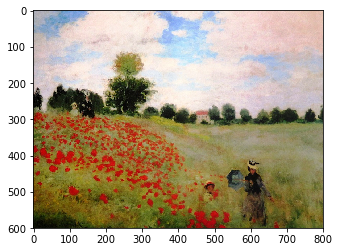

In [6]:
# Style to alter the previous image
style_image = scipy.misc.imread("images/monet_800600.jpg")
imshow(style_image)

In [7]:
# COmputing of the Gram Matrix (Style Matrix), comparing how similar are two matrices (pictures)

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [8]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[  6.42230511  -4.42912197  -2.09668207]
 [ -4.42912197  19.46583748  19.56387138]
 [ -2.09668207  19.56387138  20.6864624 ]]


In [9]:
# Computation of the Style Tranfer cost between 2 matrices

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.reshape(tf.transpose(a_S), (n_C, n_H*n_W))
    a_G = tf.reshape(tf.transpose(a_G), (n_C, n_H*n_W))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    # Computing the loss (≈1 line)
    J_style_layer = 1/(4*(n_C**2)*(n_W*n_H)**2)*tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
    
    return J_style_layer

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.19028


In [11]:
# Setting the weights to compute the style cost using several layers
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [12]:
# Computes the style cost from several layers from the model
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [13]:
# Defines the total cost from the style cost and content cost

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha*J_content +beta*J_style
    
    return J

In [14]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


In [24]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [25]:
content_image = scipy.misc.imread("images/teste.png")
content_image = reshape_and_normalize_image(content_image)

In [26]:
content_image.shape

(1, 300, 400, 3)

In [36]:
style_image = scipy.misc.imread("images/vangogh.png")
style_image = reshape_and_normalize_image(style_image)

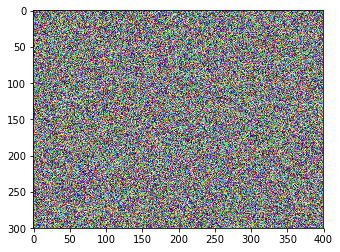

In [37]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [38]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [39]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [40]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [41]:
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [42]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [ ]:
# Defines the NN models
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [ ]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 1.17778e+10
content cost = 7284.05
style cost = 2.94444e+08
Iteration 20 :
total cost = 2.11605e+09
content cost = 18511.2
style cost = 5.28966e+07
Iteration 40 :
total cost = 6.52955e+08
content cost = 19099.2
style cost = 1.63191e+07
Iteration 60 :
total cost = 3.0224e+08
content cost = 19502.3
style cost = 7.55112e+06
Iteration 80 :
total cost = 1.97021e+08
content cost = 19748.6
style cost = 4.9206e+06
Iteration 100 :
total cost = 1.45443e+08
content cost = 20034.3
style cost = 3.63107e+06
Iteration 120 :
total cost = 1.13704e+08
content cost = 20260.4
style cost = 2.83755e+06
Iteration 140 :
total cost = 9.20277e+07
content cost = 20456.3
style cost = 2.29558e+06


KeyboardInterrupt: 

### References:

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, Convolutional neural networks for artistic style transfer. https://harishnarayanan.org/writing/artistic-style-transfer/
- Log0, TensorFlow Implementation of "A Neural Algorithm of Artistic Style". http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style
- Karen Simonyan and Andrew Zisserman (2015). Very deep convolutional networks for large-scale image recognition (https://arxiv.org/pdf/1409.1556.pdf)
- MatConvNet. http://www.vlfeat.org/matconvnet/pretrained/
- https://www.coursera.org/specializations/deep-learning